In [1]:
import logging

import matplotlib.pyplot as plt
import numpy as np
from PIL import Image as PILImage
import torch

from aspire.classification import RIRClass2D, TopClassSelector
from aspire.image import Image
from aspire.noise import WhiteNoiseAdder
from aspire.source import ArrayImageSource  # Helpful hint if you want to BYO array.
from aspire.utils import gaussian_2d
from aspire.basis import FSPCABasis, SteerableBasis2D

logger = logging.getLogger(__name__)
L = 100
round_disc = gaussian_2d(L, sigma=L / 4)
oval_disc = gaussian_2d(L, sigma=(L / 20, L / 5))
# Create a second oval.
oval_disc2 = gaussian_2d(L, mu=(L / 5, L / 6), sigma=(L / 15, L / 20))

# Strategically add it to `oval_disc`.
yoval_discL = oval_disc.copy()
yoval_discL += oval_disc2
yoval_discR = np.flipud(yoval_discL)
# How many entries (angles) in our stack
N = 512
thetas = np.linspace(start=0, stop=360, num=N, endpoint=False)

classRound = np.zeros((N, L, L))
classOval = np.zeros((N, L, L))
classYOvalL = np.zeros((N, L, L))
classYOvalR = np.zeros((N, L, L))

for i, theta in enumerate(thetas):
    classRound[i] = np.asarray(PILImage.fromarray(round_disc).rotate(theta))
    classOval[i] = np.asarray(PILImage.fromarray(oval_disc).rotate(theta))
    classYOvalL[i] = np.asarray(PILImage.fromarray(yoval_discL).rotate(theta))
    classYOvalR[i] = np.asarray(PILImage.fromarray(yoval_discR).rotate(theta))

# We'll make an example data set by concatentating then shuffling these.
example_array = np.concatenate((classRound, classOval, classYOvalL, classYOvalR))
np.random.seed(1234567)
np.random.shuffle(example_array)

# So now that we have cooked up an example dataset, lets create an ASPIRE source
src = ArrayImageSource(example_array)

/home/qaddura.1/anaconda3/envs/aspire_dev/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


2023-03-30 12:40:18,285 INFO [aspire.source.image] Attempting to create an Image object from Numpy array.
2023-03-30 12:40:18,289 INFO [aspire.source.image] Creating ArrayImageSource with 2048 images.


2023-03-30 12:40:37,172 INFO [aspire.source.image] Creating ArrayImageSource with 2048 images.


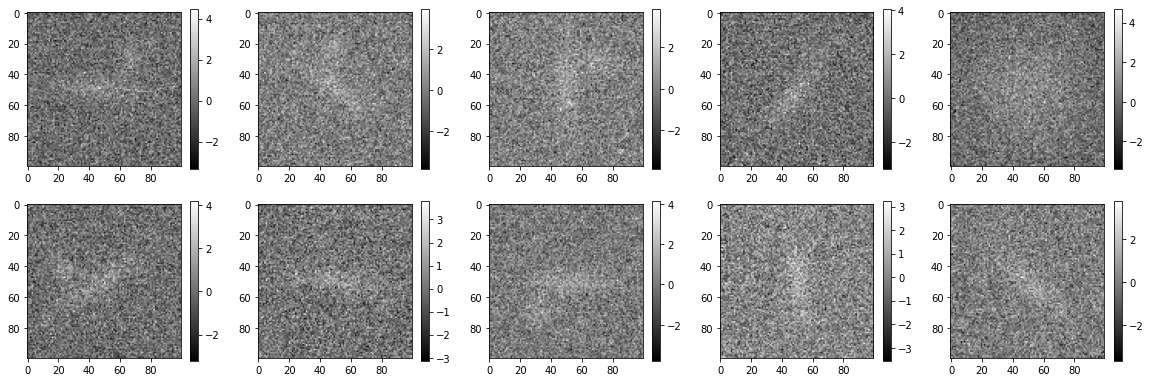

In [2]:
# Using the sample variance, we'll compute a target noise variance
# Noise
var = np.var(src.images[:].asnumpy())
noise_var = var * 2**4

# Then create noise with the ``WhiteNoiseAdder`` class.
noise = WhiteNoiseAdder(var=noise_var, seed=123)

# Add noise to the images by performing ``forward``
noisy_im = noise.forward(src.images[:])

# Recast as an ASPIRE source
noisy_src = ArrayImageSource(noisy_im)

# Let's peek at the noisey images
noisy_src.images[:10].show()

In [3]:
noisy_rir_max = RIRClass2D(
    noisy_src,
    fspca_components= 20,
    bispectrum_components=20,
    n_nbor=10,
    n_classes=10,
    large_pca_implementation="legacy",
    nn_implementation="sklearn",
    max_filter=True,
    max_filter_method="fft",
    max_filter_fft_padding = 400,
    max_filter_template_selection = "random_source",
    bispectrum_implementation="legacy",
    templates = 40,
    num_procs=1,  # Change to "auto" if your machine has many processors
)

classes_max, reflections_max, dists_max = noisy_rir_max.classify()
avgs_max = noisy_rir_max.averages(classes_max, reflections_max, dists_max)

2023-03-30 12:41:14,345 INFO [aspire.basis.ffb_2d] Expanding 2D image in a frequency-domain Fourier–Bessel basis using the fast method.
2023-03-30 12:41:16,805 INFO [aspire.basis.fspca] Estimating the noise of images.
2023-03-30 12:41:16,829 INFO [aspire.noise.noise] Determining Noise variance in batches of 512


100%|██████████| 4/4 [00:00<00:00, 12.48it/s]

2023-03-30 12:41:17,205 INFO [aspire.noise.noise] Noise variance = 0.9117873916386764
2023-03-30 12:41:17,209 INFO [aspire.basis.fspca] Setting noise_var=0.9117873916386764
2023-03-30 12:41:17,212 INFO [aspire.covariance.covar2d] Represent CTF filters in FB basis
2023-03-30 12:41:17,296 INFO [aspire.nufft] Trying NFFT backend cufinufft
2023-03-30 12:41:17,306 INFO [aspire.nufft] NFFT backend cufinufft not usable:
	No module named 'pycuda'


2023-03-30 12:41:17,312 INFO [aspire.nufft] Trying NFFT backend finufft
2023-03-30 12:41:17,347 INFO [aspire.nufft] NFFT backend finufft usable.
2023-03-30 12:41:17,377 INFO [aspire.nufft] Trying NFFT backend pynfft
2023-03-30 12:41:17,379 INFO [aspire.nufft] NFFT backend pynfft not usable:
	No module named 'pynfft'
2023-03-30 12:41:17,380 INFO [aspire.nufft] Selected NFFT backend = finufft.


RuntimeError: The data has an uncaught error that led to the planner returning NULL. This is a bug.

In [ ]:
avgs_max.images[:10].show()